In [3]:
import nltk
import numpy as np

import feature_engineering as f_eng
import data_splitting as d_spl
import models as md
import variables as var

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\volod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\volod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\volod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df_data = f_eng.get_ready_data(6)

## Тестируем на количественных данных

Распределение классов во всем датасете

In [3]:
df_data['FTR'].value_counts() / len(df_data)

H    0.452834
A    0.303644
D    0.243522
Name: FTR, dtype: float64

Возьмем датасет с валидными количественными данными и разобьем на train и test в отношении 85 на 15 (так как сетка в дальнейшем обучается на train и validation из суммарно 85% объектов)

In [44]:
df_quantitative = d_spl.get_valid_quantitative_dataset(df_data)
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time(df_quantitative, var.columns_features_q, var.column_result, train_q=0.85, valid_q=0)

Sample sizes:

Total: 4155
Train sample: 3531, 0.8498194945848375
0    0.463325
2    0.292552
1    0.244123
Name: FTR, dtype: float64
Validation sample: 0, 0.0
Series([], Name: FTR, dtype: float64)
Test sample: 624, 0.15018050541516245
0    0.451923
2    0.317308
1    0.230769
Name: FTR, dtype: float64


Проверим модель, всегда предсказывающую самый частый класс и опирающуюся на эмпирическое распределение

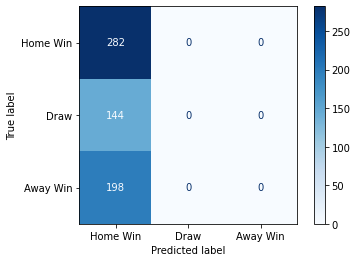

              precision    recall  f1-score   support

    Home Win     0.4519    1.0000    0.6225       282
        Draw     0.0000    0.0000    0.0000       144
    Away Win     0.0000    0.0000    0.0000       198

    accuracy                         0.4519       624
   macro avg     0.1506    0.3333    0.2075       624
weighted avg     0.2042    0.4519    0.2813       624

RPS:  0.4326923076923077


In [8]:
dc_mf = md.train_dummy_most_frequent(X_train, y_train)
md.show_metrics(dc_mf, X_test, y_test)

Проверим случайный лес с фиксированными гиперпараметрами

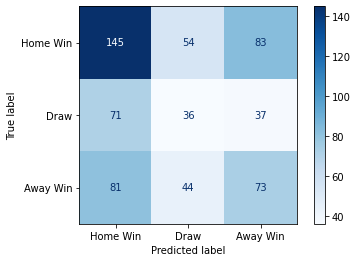

              precision    recall  f1-score   support

    Home Win     0.4882    0.5142    0.5009       282
        Draw     0.2687    0.2500    0.2590       144
    Away Win     0.3782    0.3687    0.3734       198

    accuracy                         0.4071       624
   macro avg     0.3784    0.3776    0.3778       624
weighted avg     0.4027    0.4071    0.4046       624

RPS:  0.42788461538461536


In [45]:
dc_mf = md.train_dummy_stratified(X_train, y_train)
md.show_metrics(dc_mf, X_test, y_test)

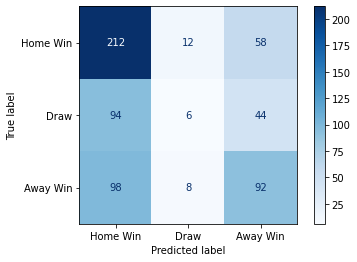

              precision    recall  f1-score   support

    Home Win     0.5248    0.7518    0.6181       282
        Draw     0.2308    0.0417    0.0706       144
    Away Win     0.4742    0.4646    0.4694       198

    accuracy                         0.4968       624
   macro avg     0.4099    0.4194    0.3860       624
weighted avg     0.4409    0.4968    0.4446       624

RPS:  0.21273998397435898


In [9]:
basic_rf = md.train_basic_random_forest(X_train, y_train)
md.show_metrics(basic_rf, X_test, y_test)

Разобьем данные в отношении 70 : 15 : 15 и протестируем перебор гиперпараметров по сетке

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time(df_quantitative, var.columns_features_q, var.column_result, train_q=0.7, valid_q=0.15)

Sample sizes:

Total: 4155
Train sample: 2907, 0.699638989169675
0    0.458548
2    0.288958
1    0.252494
Name: FTR, dtype: float64
Validation sample: 624, 0.15018050541516245
0    0.485577
2    0.309295
1    0.205128
Name: FTR, dtype: float64
Test sample: 624, 0.15018050541516245
0    0.451923
2    0.317308
1    0.230769
Name: FTR, dtype: float64


In [16]:
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini'],
    'max_depth': np.arange(3, 13, 1),
    'min_samples_split': [5, 10, 20, 50, 75, 100],
    'n_estimators': [50, 100, 150, 200]
}
grid_rf_search = md.train_rf_grid(X_train, y_train, X_val, y_val, param_grid)
grid_rf = grid_rf_search.best_estimator_
grid_rf_search.best_params_, grid_rf_search.best_score_

Fitting 1 folds for each of 480 candidates, totalling 480 fits


({'criterion': 'gini',
  'max_depth': 4,
  'max_features': 'sqrt',
  'min_samples_split': 10,
  'n_estimators': 50},
 0.5913461538461539)

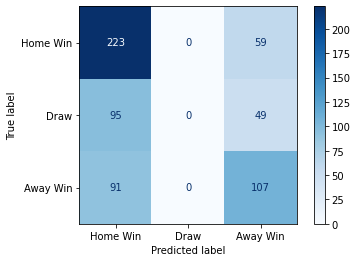

              precision    recall  f1-score   support

    Home Win     0.5452    0.7908    0.6454       282
        Draw     0.0000    0.0000    0.0000       144
    Away Win     0.4977    0.5404    0.5182       198

    accuracy                         0.5288       624
   macro avg     0.3476    0.4437    0.3879       624
weighted avg     0.4043    0.5288    0.4561       624

RPS:  0.2068815216079375


In [17]:
md.show_metrics(grid_rf, X_test, y_test)

## Тестируем обучение на превью

Попробуем лемматизацию

In [18]:
df_previews = d_spl.get_valid_preview_dataset(df_data)
df_previews = f_eng.lemmatize_df(df_previews)
vec = f_eng.create_count_vectorizer(df_previews)
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time_vectorize(df_previews, var.columns_features_pr, var.column_result, vec)

Sample sizes:

Total: 3993
Train sample: 2791, 0.6989732031054345
0    0.442852
2    0.300967
1    0.256181
Name: FTR, dtype: float64
Validation sample: 598, 0.14976208364638116
0    0.500000
2    0.302676
1    0.197324
Name: FTR, dtype: float64
Test sample: 604, 0.15126471324818433
0    0.461921
2    0.302980
1    0.235099
Name: FTR, dtype: float64


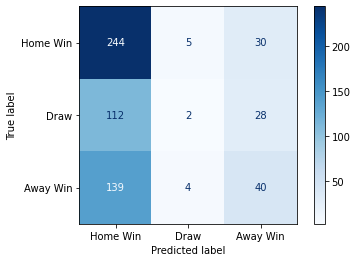

              precision    recall  f1-score   support

    Home Win     0.4929    0.8746    0.6305       279
        Draw     0.1818    0.0141    0.0261       142
    Away Win     0.4082    0.2186    0.2847       183

    accuracy                         0.4735       604
   macro avg     0.3610    0.3691    0.3138       604
weighted avg     0.3941    0.4735    0.3836       604

RPS:  0.22324963931964534


In [20]:
rf_lemmatizer = md.train_basic_random_forest(X_train, y_train)
md.show_metrics(rf_lemmatizer, X_test, y_test)

Попробуем стемминг

In [21]:
df_previews = d_spl.get_valid_preview_dataset(df_data)
df_previews = f_eng.stem_df(df_previews)
vec = f_eng.create_count_vectorizer(df_previews)
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time_vectorize(df_previews, var.columns_features_pr, var.column_result, vec)

Sample sizes:

Total: 3993
Train sample: 2791, 0.6989732031054345
0    0.442852
2    0.300967
1    0.256181
Name: FTR, dtype: float64
Validation sample: 598, 0.14976208364638116
0    0.500000
2    0.302676
1    0.197324
Name: FTR, dtype: float64
Test sample: 604, 0.15126471324818433
0    0.461921
2    0.302980
1    0.235099
Name: FTR, dtype: float64


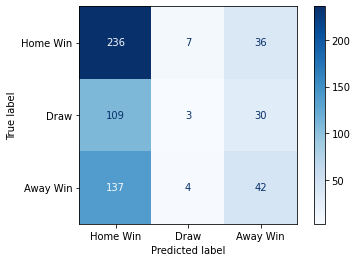

              precision    recall  f1-score   support

    Home Win     0.4896    0.8459    0.6202       279
        Draw     0.2143    0.0211    0.0385       142
    Away Win     0.3889    0.2295    0.2887       183

    accuracy                         0.4652       604
   macro avg     0.3643    0.3655    0.3158       604
weighted avg     0.3944    0.4652    0.3830       604

RPS:  0.22240901303813992


In [22]:
rf_stemming = md.train_basic_random_forest(X_train, y_train)
md.show_metrics(rf_stemming, X_test, y_test)

Теперь сравним на примере лемматизации перебор по сетки

In [27]:
df_previews = d_spl.get_valid_preview_dataset(df_data)
df_previews = f_eng.lemmatize_df(df_previews)
vec = f_eng.create_count_vectorizer(df_previews)
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time_vectorize(df_previews, var.columns_features_pr, var.column_result, vec, train_q=0.85, valid_q=0)

Sample sizes:

Total: 3993
Train sample: 3389, 0.8487352867518156
0    0.452936
2    0.301269
1    0.245795
Name: FTR, dtype: float64
Validation sample: 0, 0.0
Series([], Name: FTR, dtype: float64)
Test sample: 604, 0.15126471324818433
0    0.461921
2    0.302980
1    0.235099
Name: FTR, dtype: float64


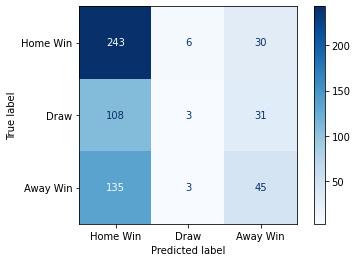

              precision    recall  f1-score   support

    Home Win     0.5000    0.8710    0.6353       279
        Draw     0.2500    0.0211    0.0390       142
    Away Win     0.4245    0.2459    0.3114       183

    accuracy                         0.4818       604
   macro avg     0.3915    0.3793    0.3286       604
weighted avg     0.4184    0.4818    0.3970       604

RPS:  0.222033797704156


In [31]:
rf_lemmatizer = md.train_basic_random_forest(X_train, y_train)
md.show_metrics(rf_lemmatizer, X_test, y_test)

In [32]:
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time_vectorize(df_previews, var.columns_features_pr, var.column_result, vec, train_q=0.7, valid_q=0.15)

Sample sizes:

Total: 3993
Train sample: 2791, 0.6989732031054345
0    0.442852
2    0.300967
1    0.256181
Name: FTR, dtype: float64
Validation sample: 598, 0.14976208364638116
0    0.500000
2    0.302676
1    0.197324
Name: FTR, dtype: float64
Test sample: 604, 0.15126471324818433
0    0.461921
2    0.302980
1    0.235099
Name: FTR, dtype: float64


In [34]:
param_grid = {
    'max_features': ['sqrt'],
    'criterion': ['gini'],
    'max_depth': np.arange(10, 100, 5),
    'min_samples_split': [5, 10, 20, 50, 75, 100],
    'n_estimators': [50, 100, 150, 200, 400]
}
grid_rf_search_pr = md.train_rf_grid(X_train, y_train, X_val, y_val, param_grid)
grid_rf_pr = grid_rf_search_pr.best_estimator_
grid_rf_search_pr.best_params_, grid_rf_search_pr.best_score_

Fitting 1 folds for each of 540 candidates, totalling 540 fits


({'criterion': 'gini',
  'max_depth': 85,
  'max_features': 'sqrt',
  'min_samples_split': 5,
  'n_estimators': 400},
 0.5334448160535117)

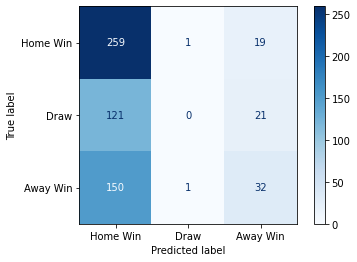

              precision    recall  f1-score   support

    Home Win     0.4887    0.9283    0.6403       279
        Draw     0.0000    0.0000    0.0000       142
    Away Win     0.4444    0.1749    0.2510       183

    accuracy                         0.4818       604
   macro avg     0.3110    0.3677    0.2971       604
weighted avg     0.3604    0.4818    0.3718       604

RPS:  0.21973888566782732


In [35]:
md.show_metrics(grid_rf_pr, X_test, y_test)

## Стекинг

In [36]:
df_train = d_spl.get_valid_dataset(df_data)
df_train = f_eng.stem_df(df_train)
X_train, X_val, X_test, y_train, y_val, y_test = d_spl.split_data_by_time(df_train, var.columns_features_pr + var.columns_features_q, var.column_result, train_q=0.55, valid_q=0.30)
vec = f_eng.create_count_vectorizer(df_train)

Sample sizes:

Total: 3246
Train sample: 1785, 0.5499075785582255
0    0.454902
2    0.284594
1    0.260504
Name: FTR, dtype: float64
Validation sample: 971, 0.2991373998767714
0    0.490216
2    0.302781
1    0.207003
Name: FTR, dtype: float64
Test sample: 490, 0.15095502156500307
0    0.465306
2    0.300000
1    0.234694
Name: FTR, dtype: float64


Случайный лес на количественных данных

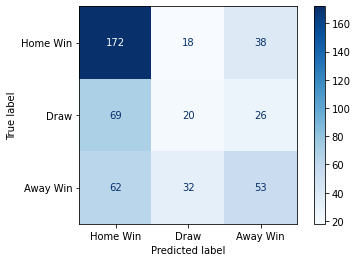

              precision    recall  f1-score   support

    Home Win     0.5677    0.7544    0.6478       228
        Draw     0.2857    0.1739    0.2162       115
    Away Win     0.4530    0.3605    0.4015       147

    accuracy                         0.5000       490
   macro avg     0.4355    0.4296    0.4219       490
weighted avg     0.4671    0.5000    0.4726       490

RPS:  0.21172418367346937


In [37]:
rf_quantitative = md.train_basic_random_forest(X_train[var.columns_features_q], y_train)
md.show_metrics(rf_quantitative, X_test[var.columns_features_q], y_test)

Случайный лес на текстовых данных со стеммингом

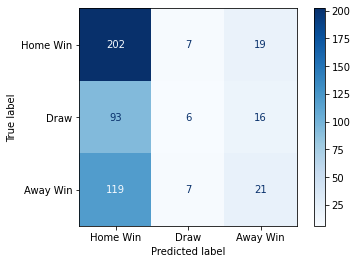

              precision    recall  f1-score   support

    Home Win     0.4879    0.8860    0.6293       228
        Draw     0.3000    0.0522    0.0889       115
    Away Win     0.3750    0.1429    0.2069       147

    accuracy                         0.4673       490
   macro avg     0.3876    0.3603    0.3084       490
weighted avg     0.4099    0.4673    0.3757       490

RPS:  0.22351679912211628


In [38]:
rf_previews = md.train_basic_random_forest(d_spl.apply_count_vectorizer(X_train[var.columns_features_pr], vec), y_train)
md.show_metrics(rf_previews, d_spl.apply_count_vectorizer(X_test[var.columns_features_pr], vec), y_test)

Считаем предсказания на валидационной и тестовой выборке для обучения стекинга

In [42]:
y_quantitative_proba_val = rf_quantitative.predict_proba(X_val[var.columns_features_q])
y_previews_proba_val = rf_previews.predict_proba(d_spl.apply_count_vectorizer(X_val[var.columns_features_pr], vec))
X_proba_val = np.append(y_quantitative_proba_val, y_previews_proba_val, axis=1)

y_quantitative_proba_test = rf_quantitative.predict_proba(X_test[var.columns_features_q])
y_previews_proba_test = rf_previews.predict_proba(d_spl.apply_count_vectorizer(X_test[var.columns_features_pr], vec))
X_proba_test = np.append(y_quantitative_proba_test, y_previews_proba_test, axis=1)

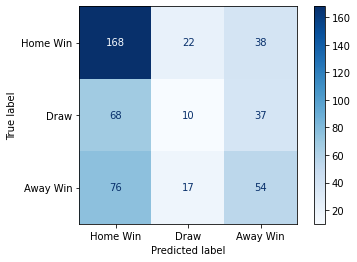

              precision    recall  f1-score   support

    Home Win     0.5385    0.7368    0.6222       228
        Draw     0.2041    0.0870    0.1220       115
    Away Win     0.4186    0.3673    0.3913       147

    accuracy                         0.4735       490
   macro avg     0.3870    0.3970    0.3785       490
weighted avg     0.4240    0.4735    0.4355       490

RPS:  0.2292411806405896


In [43]:
rf_stack = md.train_basic_random_forest(X_proba_val, y_val)
md.show_metrics(rf_stack, X_proba_test, y_test)